#### Libraries

In [1]:
import time
import numpy as np
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms

import matplotlib.pyplot as plt

#### Datasets

In [2]:
mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transforms, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=mnist_transforms, download=True)

Processing...
Done!


In [3]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=2)

### (a) Early stopping and weight decay

In [135]:
class MLP (nn.Module):
    """MLP Classifier with 2 hidden layers"""  
    def __init__(self, h0, h1, h2, h3, init_method = 'glorot'):
        super(MLP,self).__init__()
        
        # Creating layers
        self.hidden1 = nn.Linear(h0, h1, bias=True)
        self.hidden2 = nn.Linear(h1, h2, bias=True)
        self.hidden3 = nn.Linear(h2, h3, bias=True)
        
        # Initializing layers
        self.initialize(self.hidden1)
        self.initialize(self.hidden2)
        self.initialize(self.hidden3)
                       
    def forward(self, x):
        x = x.view(-1, 28*28)
        out = F.relu(self.hidden1(x))
        out = F.relu(self.hidden2(out))
        out = self.hidden3(out)
        return out
    
    def predict(self, x):
        out = F.softmax(self.forward(x), dim=1)
        return out
    
    def initialize(self, layer):
        for k,v in layer.named_parameters():
            if k == 'weight':
                init.xavier_uniform(v)
            if k == 'bias': 
                init.uniform(v, 0, 0)
                
def l2norm (layer):
    for k,v in layer.named_parameters():
        if k =='weight':
            return torch.norm(v, 2)

In [297]:
def training(clf, trainloader, loss_fn, optimizer, epochs=10, verbose = True):
    mean_losses = []
    train_accuracy = []
    l2norm_layer1 =np.array([])
    l2norm_layer2 =np.array([])
    l2norm_layer3 =np.array([])
    
    clf.train()
    for epoch in range(epochs):
        losses = []
        # Train
        total = 0
        correct = 0
        t0 = time.clock()
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            optimizer.zero_grad()
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = clf(inputs)
            loss = loss_fn (outputs, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])

            # Training accuracy
            _, predicted_train = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted_train.eq(targets.data).sum()
            
            # Stock the l2 norms
            #l2norm_layer1 = np.concatenate((l2norm_layer1, l2norm(clf.hidden1).data.numpy()))  
            #l2norm_layer2 = np.concatenate((l2norm_layer2, l2norm(clf.hidden2).data.numpy()))  
            #l2norm_layer3 = np.concatenate((l2norm_layer3, l2norm(clf.hidden3).data.numpy()))  
                        
        t1 = time.clock()    
        mean_losses.append(np.mean(losses))
        accuracy = 100.0 * correct/total
        train_accuracy.append(accuracy)
        if verbose == True:
            print('Epoch :', epoch)
            print('Loss : ',np.mean(losses))
            print('Train Acc : ', accuracy, '%')
            print("Training time took :", t1-t0, " secondes")
            print('-----------------')
    data = {'mean_losses' : mean_losses,'train_accuracy' : train_accuracy, 
            'l2norm_layer1': l2norm_layer1,
            'l2norm_layer2': l2norm_layer2,
            'l2norm_layer3': l2norm_layer3}
    return data

##### With no decay

In [137]:
# Weights and loss function:
h0, h1, h2, h3 = 784, 10, 10, 10
loss_fn = nn.CrossEntropyLoss()
epochs = 10

In [138]:
# Glorot initialization
clf = MLP(h0, h1, h2, h3)
optimizer = torch.optim.SGD(clf.parameters(),lr=0.02)
train_nodecay = training(clf, trainloader, loss_fn, optimizer, epochs, verbose = True)

Epoch : 0
Loss :  1.00230149861
Train Acc :  67.31 %
Training time took : 4.310684745250001  secondes
-----------------
Epoch : 1
Loss :  0.437207603633
Train Acc :  87.33833333333334 %
Training time took : 4.166363012360307  secondes
-----------------
Epoch : 2
Loss :  0.371538317153
Train Acc :  89.34833333333333 %
Training time took : 4.189118201031306  secondes
-----------------
Epoch : 3
Loss :  0.333593296765
Train Acc :  90.36 %
Training time took : 4.236234155649072  secondes
-----------------
Epoch : 4
Loss :  0.308837741097
Train Acc :  91.115 %
Training time took : 4.390275563204341  secondes
-----------------
Epoch : 5
Loss :  0.291331942195
Train Acc :  91.705 %
Training time took : 4.4432222552468374  secondes
-----------------
Epoch : 6
Loss :  0.278011647837
Train Acc :  92.06333333333333 %
Training time took : 4.829264447732385  secondes
-----------------
Epoch : 7
Loss :  0.267472220279
Train Acc :  92.395 %
Training time took : 4.68584751983235  secondes
------------

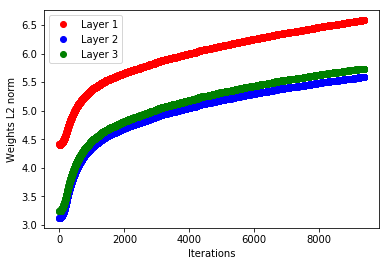

In [139]:
x = range(0,len(train_nodecay['l2norm_layer1']))
plt.plot(x, train_nodecay['l2norm_layer1'], 'ro', label = "Layer 1")
plt.plot(x, train_nodecay['l2norm_layer2'], 'bo', label = "Layer 2")
plt.plot(x, train_nodecay['l2norm_layer3'], 'go', label = "Layer 3")
plt.xlabel('Iterations')
plt.ylabel('Weights L2 norm')
plt.legend()
plt.show()

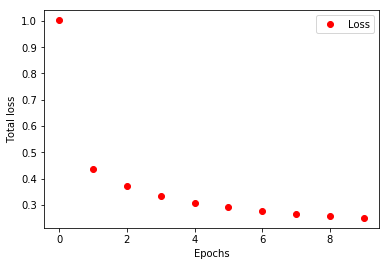

In [140]:
x = range(0, epochs)
plt.plot(x, train_nodecay['mean_losses'], 'ro', label = "Loss")
plt.xlabel('Epochs')
plt.ylabel('Total loss')
plt.legend()
plt.show()

##### With L2 regularisation

In [141]:
print('Number of training examples: ',len(trainloader))

Number of training examples:  938


We want $ \lambda = 2.5 $ on the whole training set. 
Using mini-batch of size 64 give us a new $\lambda'$ such as

$$ \lambda' = \frac{64}{n_{train}}\lambda = \frac{64}{938}* 2.5 $$

$$ \lambda' = 0.17$$

In [142]:
# Weights and loss function:
h0, h1, h2, h3 = 784, 10, 10, 10
loss_fn = nn.CrossEntropyLoss()
epochs = 10

In [143]:
# Glorot initialization
clf = MLP(h0, h1, h2, h3)
optimizer = torch.optim.SGD(clf.parameters(),lr=0.02, weight_decay=0.17)
train_decay = training(clf, trainloader, loss_fn, optimizer, epochs, verbose = True)

Epoch : 0
Loss :  2.1727104398
Train Acc :  21.805 %
Training time took : 4.304217688526478  secondes
-----------------
Epoch : 1
Loss :  2.01813890964
Train Acc :  24.865 %
Training time took : 4.413072625790846  secondes
-----------------
Epoch : 2
Loss :  1.92718420189
Train Acc :  31.74 %
Training time took : 4.5478048215754825  secondes
-----------------
Epoch : 3
Loss :  1.89636631243
Train Acc :  33.20166666666667 %
Training time took : 4.3826114051407785  secondes
-----------------
Epoch : 4
Loss :  1.8891696602
Train Acc :  33.215 %
Training time took : 4.202278926254621  secondes
-----------------
Epoch : 5
Loss :  1.88635867084
Train Acc :  33.54666666666667 %
Training time took : 4.438319722942651  secondes
-----------------
Epoch : 6
Loss :  1.88847227887
Train Acc :  33.693333333333335 %
Training time took : 4.881775979480153  secondes
-----------------
Epoch : 7
Loss :  1.88468220836
Train Acc :  33.685 %
Training time took : 4.3077962661600395  secondes
----------------

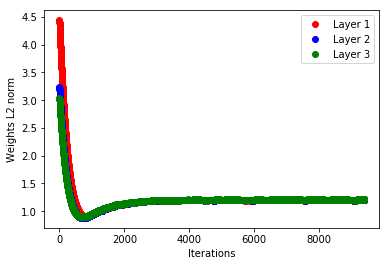

In [144]:
x = range(0,len(train_decay['l2norm_layer1']))
plt.plot(x, train_decay['l2norm_layer1'], 'ro', label = "Layer 1")
plt.plot(x, train_decay['l2norm_layer2'], 'bo', label = "Layer 2")
plt.plot(x, train_decay['l2norm_layer3'], 'go', label = "Layer 3")
plt.xlabel('Iterations')
plt.ylabel('Weights L2 norm')
plt.legend()
plt.show()

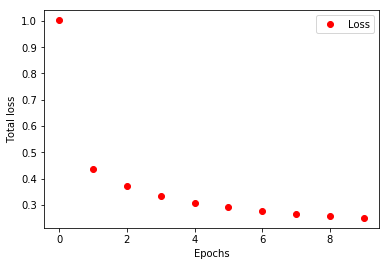

In [145]:
x = range(0, epochs)
plt.plot(x, train_nodecay['mean_losses'], 'ro', label = "Loss")
plt.xlabel('Epochs')
plt.ylabel('Total loss')
plt.legend()
plt.show()

### (b) Dropout

##### Training the model

In [190]:
class MLP2 (nn.Module):
    """MLP Classifier with 2 hidden layers and dropout"""  
    def __init__(self, h0, h1, h2, h3, init_method = 'glorot'):
        super(MLP2,self).__init__()
        
        # Creating layers
        self.hidden1 = nn.Linear(h0, h1, bias=True)
        self.hidden2 = nn.Linear(h1, h2, bias=True)
        self.hidden3 = nn.Linear(h2, h3, bias=True)
        
        # Initializing layers
        self.initialize(self.hidden1)
        self.initialize(self.hidden2)
        self.initialize(self.hidden3)
                       
    def forward(self, x):
        x = x.view(-1, 28*28)
        out = F.relu(self.hidden1(x))
        out = F.relu(self.hidden2(out))
        out = F.dropout(out,p=0.5)
        out = self.hidden3(out)
        return out
    
    def predict(self, x):
        out = F.softmax(self.forward(x), dim=1)
        return out
    
    def initialize(self, layer):
        for k,v in layer.named_parameters():
            if k == 'weight':
                init.xavier_uniform(v)
            if k == 'bias': 
                init.uniform(v, 0, 0)

In [263]:
# Weights and loss function:
h0, h1, h2, h3 = 784, 10, 10, 10
loss_fn = nn.CrossEntropyLoss()
epochs = 10

In [264]:
# Glorot initialization
clf = MLP2(h0, h1, h2, h3)
optimizer = torch.optim.SGD(clf.parameters(),lr=0.02)
train_dropout = training(clf, trainloader, loss_fn, optimizer, epochs, verbose = True)

Epoch : 0
Loss :  0.974596389353
Train Acc :  69.61 %
Training time took : 4.552794796469243  secondes
-----------------
Epoch : 1
Loss :  0.423595039099
Train Acc :  87.57166666666667 %
Training time took : 4.345027103097891  secondes
-----------------
Epoch : 2
Loss :  0.361102384259
Train Acc :  89.47833333333334 %
Training time took : 4.63344970450089  secondes
-----------------
Epoch : 3
Loss :  0.328097686172
Train Acc :  90.50666666666666 %
Training time took : 4.445567194496107  secondes
-----------------
Epoch : 4
Loss :  0.303475009504
Train Acc :  91.22333333333333 %
Training time took : 4.608834410833879  secondes
-----------------
Epoch : 5
Loss :  0.284318348695
Train Acc :  91.81 %
Training time took : 4.749108331923708  secondes
-----------------
Epoch : 6
Loss :  0.270511150757
Train Acc :  92.26333333333334 %
Training time took : 4.305393031852873  secondes
-----------------
Epoch : 7
Loss :  0.259751222162
Train Acc :  92.525 %
Training time took : 4.225560002036218 

##### Testing

(i) Multiply 0.5 to the last hidden layer

In [261]:
def test(clf, testloader):
    clf.eval()
    # Multiplying weights of last hidden layers by 0.5
    clf.hidden2.weight.data = clf.hidden2.weight.data * 5
    accuracy = 0
    total = 0
    correct = 0
    t0 = time.clock()
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = Variable(inputs, volatile=True), Variable(targets,volatile=True)
        outputs = clf(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    t1 = time.clock()    
    accuracy = 100.0 * correct/total
    data = {'accuracy' : accuracy, 'test time': t1-t0}
    return data

In [262]:
print(test(clf,testloader))

{'accuracy': 90.1, 'test time': 1.225953288416349}


(ii) Average of N pre-softmax values before applying softmax and making prediction.

In [ ]:
def test(clf, testloader, N):
    clf.eval()  
    accuracy = 0
    total = 0
    correct = 0
    t0 = time.clock()
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = Variable(inputs, volatile=True), Variable(targets,volatile=True)
        
        outputs = clf(inputs)
        
        
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    t1 = time.clock()    
    accuracy = 100.0 * correct/total
    data = {'accuracy' : accuracy, 'test time': t1-t0}
    return data

(iii) Average of N predictions

### (c) CNN

(i) With Batch-normalization

In [294]:
class CNN(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(16),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),     
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(128, 10)

    def forward(self, x):
        return self.clf(self.conv(x).squeeze())

In [298]:
# Glorot initialization
clf = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clf.parameters(),lr=0.02)
train_CNN_batchnorm = training(clf, trainloader, loss_fn, optimizer, epochs, verbose = True)

KeyboardInterrupt: 

In [286]:
def test(clf, testloader):
    clf.eval()
    # Multiplying weights of last hidden layers by 0.5
    clf.hidden2.weight.data = clf.hidden2.weight.data * 5
    accuracy = 0
    total = 0
    correct = 0
    t0 = time.clock()
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = Variable(inputs, volatile=True), Variable(targets,volatile=True)
        outputs = clf(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    t1 = time.clock()    
    accuracy = 100.0 * correct/total
    data = {'accuracy' : accuracy, 'test time': t1-t0}
    return data

KeyboardInterrupt: 

(ii) Without Batch-normalization